# Exploring regularization for linear regression

## Goal

The goal of this lab is to explore the effect of regularization on the coefficients and accuracy of linear regression models for a toy (Ames housing) dataset.

## Set up

In [1]:
import numpy as np
import pandas as pd

np.random.seed(999)

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_wine, load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'svg'

## Load data, drop columns with missing values, one-hot encode categoricals

In [2]:
df_ames = pd.read_csv("ames.csv") # in same directory as this notebook
df_ames.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [3]:
# ignore columns with missing values for this exercise
cols_with_missing = df_ames.columns[df_ames.isnull().any()]
cols = set(df_ames.columns) - set(cols_with_missing)

X = df_ames[cols]
X = X.drop('LotArea', axis=1) # has some outliers, let's drop for stability in this lab
X = X.drop('SalePrice', axis=1)
y = df_ames['SalePrice']

X = pd.get_dummies(X) # dummy encode categorical variables
X.shape

(1460, 215)

## Examine coefficients of nonregularized OLS model

**1. Split off validation/test set and train unregularized linear regression model**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=999)

In [5]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**2. Compare the R^2 on training and test set**

In [6]:
print(f"{lm.score(X_train, y_train):.2f} R^2 on training set")
print(f"{lm.score(X_test, y_test):.2f} R^2 on test set")

0.92 R^2 on training set
-65101768534.30 R^2 on test set


**Q.** Why is the testing score much worse?

<details>
<summary>Solution</summary>
Because the unconstrained coefficients of the OLS model do not generalize well; they are over fit to the training set, which makes them performed poorly on the unseen test set.
</details>

**3. Predict $\overline{y}$ computed from training set instead of using the model; what is the R^2? on test set?**

R^2 should give 0 as the neutral value when the prediction is no better and no worse than simply predicting the average of the training set.

In [7]:
y_pred = np.full(shape=(len(y_test),1), fill_value=np.mean(y_train)) # get vector of y_train bar
r2_score(y_pred, y_test) # how well do we predict y_test using y_train bar?

0.0

**4. Extract $\beta_1, ..., \beta_p$ and count how many are close to 0**

Note: `sum(np.abs(x) < 1e-5)` is a decent way to check for values of `x` close to zero but not necessarily zero.  There is also `numpy.isclose()` but that is too strict (requires numbers to be really close to zero) for this exercise.

In [8]:
lm_beta = lm.coef_

In [9]:
sum(np.abs(lm_beta) < 1e-5) # how many close to 0?

0

**5. Plot the coefficient index versus the value**

R^2 should give 0 as the neutral value when the prediction is no better and no worse than simply predicting the average of the training set.  The coefficients should look something like the following images, depending on which training samples are chosen:

<img src="ames-ols.png" width="300"><img src="ames-ols-2.png" width="300">

(There is also some randomness probably due to how the sklearn regression model deletes collinear columns to prevent the symbolic solution that finds coefficients from failing.)

The following function is a handy way to plot the coefficients.

In [10]:
def plotbeta(beta, which, yrange=(-20_000, 20_000),fontsize=10, xlabel=True, ylabel=True, ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(4,2.5))
    ax.bar(range(len(beta)),beta)
    if xlabel:
        ax.set_xlabel("Coefficient $\\beta_i$ for $i \\geq 1$", fontsize=fontsize)
    if ylabel:
        ax.set_ylabel("Coefficient value", fontsize=fontsize)
    if yrange is not None:
        ax.set_ylim(*yrange)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}'))
    ax.set_title(f"{which} $\\overline{{\\beta}}$={np.mean(beta):.0f}, $\\sigma(\\beta)$={np.std(beta):.1f}", fontsize=fontsize)

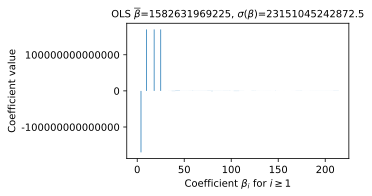

In [11]:
plotbeta(lm_beta, "OLS", yrange=None)
#plt.tight_layout(); plt.savefig("ames-ols-2.png",dpi=150,bbox_inches=0)

## Regularization

Both L1 and L2 regularization benefit from normalizing variables; sklearn has an option to do this as part of the training process, but let's do it explicitly as a way to get started.

In [12]:
def normalize(X): # well, I'm creating standard variables here (u-x)/sigma
    X = X.copy()
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        if s>0.0:
            X[colname] = (X[colname] - u) / s
        else:
            X[colname] = (X[colname] - u)
    return X

In [13]:
X_train.head(1)  # show some unnormalized values

,GrLivArea,BsmtHalfBath,Fireplaces,ScreenPorch,TotalBsmtSF,BedroomAbvGr,3SsnPorch,YearRemodAdd,KitchenAbvGr,MiscVal,...,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
1441,848,0,1,0,848,1,0,2004,1,0,...,0,0,0,0,0,1,0,0,0,0


In [14]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [15]:
X_train.head(1)  # These values should be normalized

,GrLivArea,BsmtHalfBath,Fireplaces,ScreenPorch,TotalBsmtSF,BedroomAbvGr,3SsnPorch,YearRemodAdd,KitchenAbvGr,MiscVal,...,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
1441,-1.287614,-0.250969,0.587451,-0.260696,-0.475504,-2.285696,-0.122061,0.932886,-0.212757,-0.10849,...,-0.250568,-0.135309,-0.162364,-0.065568,-0.101885,0.533787,-0.083045,-0.497859,-0.071858,-0.029273


In [16]:
# Note that the sklearn model constructors call the parameter `alpha` not `lmbda`.
lmbda = 5

## L1 (Lasso) regularization

**1. Train an L1 (lasso) linear regression model using lmbda**

In [17]:
lasso = ...
# fit model to X,y

<details>
<summary>Solution</summary>
<pre>
lasso = Lasso(alpha=lmbda, tol=.1)
lasso.fit(X_train, y_train)
</pre>
</details>

**2. Examine the training and testing scores**

Note that the sklearn model constructors call the parameter `alpha` not `lmbda`.

In [18]:
print(f"{lasso.score(X_train, y_train):.2f} R^2 on training set")
print(f"{lasso.score(X_test, y_test):.2f} R^2 on test set")

AttributeError: 'ellipsis' object has no attribute 'score'

**Q.** Why is the testing score much worse than the training score?

<details>
<summary>Solution</summary>
Because the lambda hyperparameter is small, 5, the coefficients are similar to those of the OLS model which do not generalize well; the coefficients are overfit to the training set, which makes them performed poorly on the unseen test set.
</details>

**Q.** Why is the training score about the same for OLS and regularized regression?

<details>
<summary>Solution</summary>
Regularization is mostly about generalization and training scores tell us nothing about generalization.
</details>

**3.  Count how many $\beta_{1..p}$ coefficients are (close to) zero**

In [ ]:
sum(...) # how many close to 0?

<details>
<summary>Solution</summary>
<pre>
lasso_beta = lasso.coef_
sum(np.abs(lasso_beta) < 1e-5) # how many close to 0?
</pre>
</details>

**4. Plot the  $\beta_{1..p}$ coefficients using `plotbeta`**

In [ ]:
plotbeta(lasso.coef_, "Lasso $\lambda="+str(lmbda)+"$: ")

## L2 (Ridge) regularization

**1. Train an L2 (Ridge) linear regression model using lmbda**

Note that the sklearn model constructors call the parameter `alpha` not `lmbda`.

In [ ]:
ridge = ...
# fit to X,y

<details>
<summary>Solution</summary>
<pre>
ridge = Ridge(alpha=lmbda)
ridge.fit(X_train, y_train)
</pre>
</details>

**2. Examine the training and testing scores**

In [ ]:
print(f"{ridge.score(X_train, y_train):.2f} R^2 on training set")
print(f"{ridge.score(X_test, y_test):.2f} R^2 on test set")

**Q.**  Why are the R^2 scores for L2 similar to L1?

<details>
<summary>Solution</summary>
L1 and L2 Regularization is solving the same problem: constraining the size of the coefficients. The only difference is the metric used. There both effective and so we would expect there scores to be similar.
</details>

**3.  Count how many $\beta_{1..p}$ coefficients are (close to) zero**

In [ ]:
sum(np.abs(ridge.coef_) < 1e-5) # how many close to 0?

**4. Plot the  $\beta_{1..p}$ coefficients using `plotbeta`**

In [ ]:
plotbeta(ridge.coef_, "Ridge $\lambda="+str(lmbda)+"$: ")

**Q.** Compare the standard deviation of the coefficients for L1 and L2. What do you notice visually?

<details>
<summary>Solution</summary>
The L2 coefficients are smaller and have smaller standard deviation; they are more tightly grouped. Also note that there are fewer L2 coefficients at 0.
</details>

## Effect of $\lambda$ on regularization and R^2 scores

The goal of the following code snippets is to help you visualize how the $\lambda$ regularization parameter affects model parameters and associated training and testing scores. There are a number of important questions to answer following the code snippets.

In [ ]:
fig,axes = plt.subplots(1,7,figsize=(13.5,1.8), sharey=True)
for i,lmbda in enumerate([1,10,100,200,500,1000,2000]):
    lasso = Lasso(alpha=lmbda, tol=.1)
    lasso.fit(X_train, y_train)
    r2 = lasso.score(X_train, y_train)
    r2t = lasso.score(X_test, y_test)
    print(f"lambda={lmbda:4d}: Zeros {sum(np.abs(lasso.coef_) < 1e-5):3d}: train R^2 {r2:.2f} test R^2 {r2t:.2f}")
    plotbeta(lasso.coef_, f"$\\lambda={lmbda}$\n", ax=axes[i], fontsize=9, xlabel=False, ylabel=i==0)

**Q.** Why does the training R^2 score go down as we increase lambda?

<details>
<summary>Solution</summary>
We are trading a bit of bias for improve generality. As we increase $\lambda$, we are restricting how close to the true minimum loss function location we can get.
</details>

**Q.** Why does the L1 testing R^2 score go up we increase lambda?

<details>
<summary>Solution</summary>
As we constrain the coefficients, we reduce the overfitting to the training data and hence generality improves.
</details>

**Q.** Describe what is happening to the L1 coefficients as we increase lambda?

<details>
<summary>Solution</summary>
The average magnitude of the coefficients is not changing much, but they are becoming a tighter group; the standard deviation is shrinking significantly. Many more coefficients are going to zero. Note that about 80% of the coefficients  have gone to zero when we get the best test score.
</details>

In [ ]:
fig,axes = plt.subplots(1,7,figsize=(13.5,1.8), sharey=True)
for i,lmbda in enumerate([1,10,100,200,500,1000,2000]):
    ridge = Ridge(alpha=lmbda, tol=.1)
    ridge.fit(X_train, y_train)
    r2 = ridge.score(X_train, y_train)
    r2t = ridge.score(X_test, y_test)
    print(f"lambda={lmbda:4d}: Zeros {sum(np.abs(ridge.coef_) < 1e-5)}: train R^2 {r2:.2f} test R^2 {r2t:.2f}")
    plotbeta(ridge.coef_, f"$\\lambda={lmbda}$\n", ax=axes[i], fontsize=9, xlabel=False, ylabel=i==0)

**Q.** Why does the training R^2 score go down as we increase lambda?

<details>
<summary>Solution</summary>
We are introducing bias as we did for L1, in exchange for increased generality.
</details>

**Q.** Describe what is happening to the L2 coefficients as we increase lambda?

<details>
<summary>Solution</summary>
 The average magnitude of the coefficients goes down and they become a tighter group, but not as quickly as L1. We don't get any more coefficients going to zero.
</details>

**Q.** Characterize how the magnitudes of L1 and L2 coefficients differ.

<details>
<summary>Solution</summary>
   The L2 coefficients are in general much tighter group than the L1, even as we increase $\lambda$. The L1 regularization drops many of the coefficients to zero for the same value of $\lambda$.
</details>